2026-1-11 클로드로 생성한 랭그래프 기본 예제


# 1. 기본 순차 체인 (설치부터 실행까지)

In [1]:
# 필요한 패키지 설치
# pip install langgraph langchain-openai

from langgraph.graph import StateGraph, END
from typing import TypedDict
import os

In [ ]:
# OpenAI API 키 설정 (필요시)
# os.environ["OPENAI_API_KEY"] = "your-api-key"


In [2]:
# 1. 상태 정의
class BasicState(TypedDict):
    input_text: str
    step1_result: str
    step2_result: str
    final_result: str

In [3]:
# 2. 각 단계 함수 정의
def step1_process(state):
    """첫 번째 처리 단계"""
    result = f"[단계1 완료] 입력: {state['input_text']}"
    print(f"✓ {result}")
    return {"step1_result": result}

def step2_process(state):
    """두 번째 처리 단계"""
    result = f"[단계2 완료] 이전 결과 가공: {state['step1_result']}"
    print(f"✓ {result}")
    return {"step2_result": result}

def final_process(state):
    """최종 처리 단계"""
    result = f"[최종 완료] {state['step2_result']} → 처리 완료!"
    print(f"✓ {result}")
    return {"final_result": result}

In [4]:
# 3. 그래프 생성
workflow = StateGraph(BasicState)

# 4. 노드 추가
workflow.add_node("step1", step1_process)
workflow.add_node("step2", step2_process)
workflow.add_node("final", final_process)

# 5. 엣지 연결 (순차 실행)
workflow.set_entry_point("step1")
workflow.add_edge("step1", "step2")
workflow.add_edge("step2", "final")
workflow.add_edge("final", END)

In [5]:
# 6. 컴파일
app = workflow.compile()

In [6]:
# 7. 실행
print("=" * 50)
print("순차 체인 실행")
print("=" * 50)
result = app.invoke({"input_text": "AWS 클라우드 학습"})
print("\n최종 결과:", result['final_result'])

순차 체인 실행
✓ [단계1 완료] 입력: AWS 클라우드 학습
✓ [단계2 완료] 이전 결과 가공: [단계1 완료] 입력: AWS 클라우드 학습
✓ [최종 완료] [단계2 완료] 이전 결과 가공: [단계1 완료] 입력: AWS 클라우드 학습 → 처리 완료!

최종 결과: [최종 완료] [단계2 완료] 이전 결과 가공: [단계1 완료] 입력: AWS 클라우드 학습 → 처리 완료!


# 2. 조건부 분기 체인

In [7]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# 상태 정의
class ConditionalState(TypedDict):
    user_input: str
    score: float
    category: str
    result: str

# 노드 함수들
def analyze_input(state):
    """입력 분석 및 점수 부여"""
    text = state['user_input']
    # 간단한 점수 로직 (길이 기반)
    score = min(len(text) / 100.0, 1.0)
    print(f"📊 분석 완료: 입력 길이={len(text)}, 점수={score:.2f}")
    return {"score": score}

def high_quality_handler(state):
    """고품질 처리"""
    result = f"⭐ 고품질 처리: '{state['user_input'][:30]}...' (점수: {state['score']:.2f})"
    print(result)
    return {"category": "high", "result": result}

def normal_handler(state):
    """일반 처리"""
    result = f"📝 일반 처리: '{state['user_input'][:30]}...' (점수: {state['score']:.2f})"
    print(result)
    return {"category": "normal", "result": result}

def low_quality_handler(state):
    """저품질 처리"""
    result = f"⚠️ 추가 검토 필요: '{state['user_input'][:30]}...' (점수: {state['score']:.2f})"
    print(result)
    return {"category": "low", "result": result}

In [8]:
# 라우팅 함수
def route_by_score(state):
    """점수에 따라 경로 결정"""
    score = state['score']
    if score >= 0.7:
        return "high_quality"
    elif score >= 0.3:
        return "normal"
    else:
        return "low_quality"

In [9]:
# 그래프 구성
workflow = StateGraph(ConditionalState)

workflow.add_node("analyze", analyze_input)
workflow.add_node("high_quality", high_quality_handler)
workflow.add_node("normal", normal_handler)
workflow.add_node("low_quality", low_quality_handler)

workflow.set_entry_point("analyze")
workflow.add_conditional_edges(
    "analyze",
    route_by_score,
    {
        "high_quality": "high_quality",
        "normal": "normal",
        "low_quality": "low_quality"
    }
)

workflow.add_edge("high_quality", END)
workflow.add_edge("normal", END)
workflow.add_edge("low_quality", END)

app = workflow.compile()

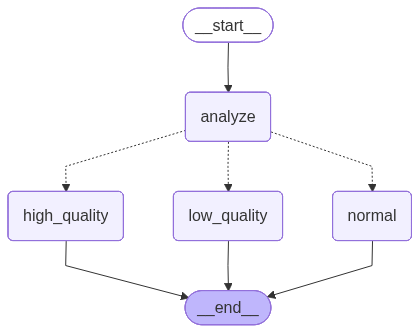

In [11]:
app

In [10]:
# 실행 테스트
print("\n" + "=" * 50)
print("조건부 분기 체인 실행")
print("=" * 50)

test_inputs = [
    "AWS는 아마존 웹 서비스로, 클라우드 컴퓨팅 플랫폼입니다. EC2, S3, RDS 등 다양한 서비스를 제공하며, 전 세계적으로 많은 기업들이 사용하고 있습니다.",
    "AWS EC2는 가상 서버입니다.",
    "클라우드"
]

for i, text in enumerate(test_inputs, 1):
    print(f"\n[테스트 {i}]")
    result = app.invoke({"user_input": text})
    print(f"결과 카테고리: {result.get('category', 'N/A')}\n")


조건부 분기 체인 실행

[테스트 1]
📊 분석 완료: 입력 길이=90, 점수=0.90
⭐ 고품질 처리: 'AWS는 아마존 웹 서비스로, 클라우드 컴퓨팅 플랫폼입...' (점수: 0.90)
결과 카테고리: high


[테스트 2]
📊 분석 완료: 입력 길이=18, 점수=0.18
⚠️ 추가 검토 필요: 'AWS EC2는 가상 서버입니다....' (점수: 0.18)
결과 카테고리: low


[테스트 3]
📊 분석 완료: 입력 길이=4, 점수=0.04
⚠️ 추가 검토 필요: '클라우드...' (점수: 0.04)
결과 카테고리: low



# 3. 루프 체인 (재시도 로직)

In [12]:
from langgraph.graph import StateGraph, END
from typing import TypedDict
import random

# 상태 정의
class RetryState(TypedDict):
    task: str
    attempt: int
    max_attempts: int
    success: bool
    result: str
    error_log: list

# 노드 함수들
def attempt_task(state):
    """작업 시도 (랜덤 성공/실패)"""
    attempt = state.get('attempt', 0) + 1
    task = state['task']
    
    # 랜덤하게 성공/실패 시뮬레이션 (60% 성공률)
    success = random.random() < 0.6
    
    print(f"🔄 시도 #{attempt}: {task}")
    
    if success:
        result = f"✅ 성공! 작업 '{task}' 완료"
        print(f"   {result}")
        return {
            "attempt": attempt,
            "success": True,
            "result": result
        }
    else:
        error = f"❌ 실패 (시도 {attempt}회)"
        print(f"   {error}")
        error_log = state.get('error_log', [])
        error_log.append(error)
        return {
            "attempt": attempt,
            "success": False,
            "error_log": error_log
        }


In [13]:
def check_retry(state):
    """재시도 여부 결정"""
    if state['success']:
        return "done"
    
    if state['attempt'] >= state['max_attempts']:
        print(f"⛔ 최대 시도 횟수({state['max_attempts']})에 도달")
        return "failed"
    
    print(f"🔁 재시도 준비 중...")
    return "retry"

def handle_failure(state):
    """실패 처리"""
    result = f"⚠️ 작업 실패: {state['task']} (총 {state['attempt']}회 시도)"
    print(result)
    return {"result": result}

In [14]:
# 그래프 구성
workflow = StateGraph(RetryState)

workflow.add_node("attempt", attempt_task)
workflow.add_node("handle_failure", handle_failure)

workflow.set_entry_point("attempt")

workflow.add_conditional_edges(
    "attempt",
    check_retry,
    {
        "retry": "attempt",      # 다시 시도
        "done": END,             # 성공 시 종료
        "failed": "handle_failure"  # 최대 시도 초과
    }
)

workflow.add_edge("handle_failure", END)


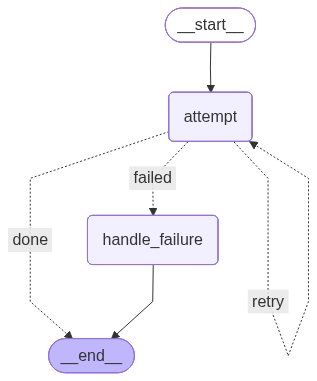

In [15]:
app = workflow.compile()
app

In [16]:
# 실행
print("\n" + "=" * 50)
print("루프 체인 실행 (재시도 로직)")
print("=" * 50)

result = app.invoke({
    "task": "데이터베이스 연결",
    "attempt": 0,
    "max_attempts": 5,
    "success": False,
    "error_log": []
})

print(f"\n최종 상태:")
print(f"  성공 여부: {result['success']}")
print(f"  시도 횟수: {result['attempt']}")
print(f"  결과: {result.get('result', 'N/A')}")
if result.get('error_log'):
    print(f"  에러 로그: {result['error_log']}")


루프 체인 실행 (재시도 로직)
🔄 시도 #1: 데이터베이스 연결
   ✅ 성공! 작업 '데이터베이스 연결' 완료

최종 상태:
  성공 여부: True
  시도 횟수: 1
  결과: ✅ 성공! 작업 '데이터베이스 연결' 완료


# 4. 통합 실행 스크립트

In [17]:
# all_examples.py
import sys

def run_all_examples():
    print("\n" + "🚀" * 25)
    print("LangGraph 체인 예제 실행")
    print("🚀" * 25)
    
    # 예제 1
    print("\n\n[1/3] 순차 체인")
    # 위의 예제 1 코드
    
    # 예제 2
    print("\n\n[2/3] 조건부 분기 체인")
    # 위의 예제 2 코드
    
    # 예제 3
    print("\n\n[3/3] 루프 체인")
    # 위의 예제 3 코드
    
    print("\n\n✅ 모든 예제 실행 완료!")

if __name__ == "__main__":
    run_all_examples()


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
LangGraph 체인 예제 실행
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀


[1/3] 순차 체인


[2/3] 조건부 분기 체인


[3/3] 루프 체인


✅ 모든 예제 실행 완료!


In [ ]:
# # 1. 패키지 설치
# pip install langgraph

# # 2. 각 예제를 개별 파일로 저장 후 실행
# python basic_chain.py
# python conditional_chain.py
# python retry_chain.py